# Análisis de sentimiento 

In [1]:
# Importamos los diálogos que tenemos en el archivo .pkl, para no tener que hacer 
# scrapping otra vez.
import pickle
file=open("dialogos.pkl",'rb')
dialogos=pickle.load(file)

In [2]:
i=dialogos[0]
i, i[i.find(':')+2:], i.find(':')+2, i[:i.find(':')+2]

('Scene: A corridor at a sperm bank.',
 'A corridor at a sperm bank.',
 7,
 'Scene: ')

In [3]:
import pandas as pd

# Creamos df
df = pd.DataFrame(columns=['dialogo', 'personaje'])

# Rellenamos el dataframe con los diálogos importados del pkl. Importante poner el 'ignore_index'
for i in dialogos:
  if i.startswith("Sheldon"):
    df = df.append({'dialogo': i[i.find(':')+2:], 'personaje':'Sheldon'}, ignore_index=True)
  elif i.startswith("Leonard"):
    df = df.append({'dialogo': i[i.find(':')+2:], 'personaje':'Leonard'}, ignore_index=True)
  elif i.startswith("Raj"):
    df = df.append({'dialogo': i[i.find(':')+2:], 'personaje':'Raj'}, ignore_index=True)
  elif i.startswith("Penny"):
    df = df.append({'dialogo': i[i.find(':')+2:], 'personaje':'Penny'}, ignore_index=True)
  elif i.startswith("Howard"):
    df = df.append({'dialogo': i[i.find(':')+2:], 'personaje':'Howard'}, ignore_index=True)

df


,dialogo,personaje
0,So if a photon is directed through a plane wit...,Sheldon
1,"Agreed, what’s your point?",Leonard
2,"There’s no point, I just think it’s a good ide...",Sheldon
3,Excuse me?,Leonard
4,"One across is Aegean, eight down is Nabakov, t...",Leonard
...,...,...
3989,"Well, it’s really not that fancy, it’s just a ...",Leonard
3990,"Right, but I have to have some sort of degree ...",Penny
3991,That doesn’t matter to me at all.,Leonard
3992,"So, it’s fine with you if I’m not smart.",Penny


In [4]:
df.shape

(3994, 2)

In [5]:
df.personaje.value_counts() # No está balanceado: Hay personajes que tienen pocas frases.

Leonard    1279
Sheldon    1206
Penny       759
Howard      475
Raj         275
Name: personaje, dtype: int64

### Preparación de los datos

In [4]:
import re

# PRIMER PREPROCESAMIENTO
# Función para eliminar caracteres no validos utilizando Regex.
def preprocessor(text):
    text = re.sub("\(.*?\)", "", text) # Para eliminar las partes del diálogo que van entre paréntesis.
    text = re.sub(r'[\W]+', ' ', text.lower()) # Eliminamos todos los caracteres que no sean palabras.
    return text

df['dialogo'] = df['dialogo'].apply(preprocessor)
df

,dialogo,personaje
0,so if a photon is directed through a plane wit...,Sheldon
1,agreed what s your point,Leonard
2,there s no point i just think it s a good idea...,Sheldon
3,excuse me,Leonard
4,one across is aegean eight down is nabakov twe...,Leonard
...,...,...
3989,well it s really not that fancy it s just a ci...,Leonard
3990,right but i have to have some sort of degree t...,Penny
3991,that doesn t matter to me at all,Leonard
3992,so it s fine with you if i m not smart,Penny


In [5]:
# Hacemos una copia de trabajo del dataframe
df_completo= df.copy()
df_completo

,dialogo,personaje
0,so if a photon is directed through a plane wit...,Sheldon
1,agreed what s your point,Leonard
2,there s no point i just think it s a good idea...,Sheldon
3,excuse me,Leonard
4,one across is aegean eight down is nabakov twe...,Leonard
...,...,...
3989,well it s really not that fancy it s just a ci...,Leonard
3990,right but i have to have some sort of degree t...,Penny
3991,that doesn t matter to me at all,Leonard
3992,so it s fine with you if i m not smart,Penny


### Tokenizacion

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
from nltk.stem.porter import PorterStemmer

porter = PorterStemmer()

def tokenizer(text):
    return nltk.word_tokenize(text,"english")

def tokenizer_porter(text):
    return [porter.stem(word) for word in tokenizer(text)]

In [8]:
# Stopwords 
stop =  nltk.corpus.stopwords.words("english")

In [9]:
# SEGUNDO PREPROCESAMIENTO
# Función que Tokeniza y Quita de las frases las stopwords y vuelve a unir en un string
def preprocessor2(text):  
    return " ".join([w for w in tokenizer_porter(text) if w not in stop])

df_completo['dialogo'] = df_completo['dialogo'].apply(preprocessor2)
df_completo


,dialogo,personaje
0,photon direct plane two slit either slit obser...,Sheldon
1,agre point,Leonard
2,point think good idea tee shirt,Sheldon
3,excus,Leonard
4,one across aegean eight nabakov twenti six acr...,Leonard
...,...,...
3989,well realli fanci citi colleg,Leonard
3990,right sort degre date,Penny
3991,matter,Leonard
3992,fine smart,Penny


### Clasificación del documento

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.asarray(df_completo.dialogo) 
y = np.asarray(df_completo.personaje) # Variable Objetivo

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2795,) (2795,)
Test set: (1199,) (1199,)


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

#Primero lo hacemos usando Pipeline (que ahorra código)
tfidf = TfidfVectorizer()
LR = LogisticRegression()
pipe = Pipeline([('vect', tfidf),('clf', LR)])

pipe.fit(X_train,y_train)
pipe.score(X_test, y_test)


array(['Howard', 'Leonard', 'Penny', 'Raj', 'Sheldon'], dtype=object)

In [12]:
# Guardamos las predicciones
y_pred = pipe.predict(X_test)

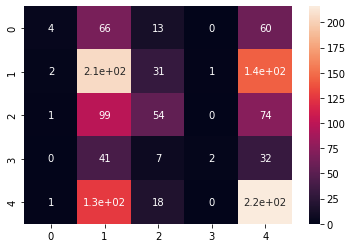

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib
import seaborn as sns

# Matriz de confusión
matriz = confusion_matrix(y_test, y_pred) 
matriz.shape

#ploteamos con seaborn
sns.heatmap(matriz, annot=True)


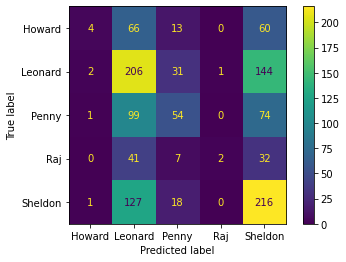

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=pipe.classes_)
disp.plot()
plt.show()

Ahora hacemos la opción de entrenar clasificador sin el Pipeline

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer()
tfidf = TfidfVectorizer()
LR = LogisticRegression()

In [90]:
#El count no es imprescindible por lo que ahora no lo hemos utilizado
X=tfidf.fit_transform(df_completo['dialogo'].values)
y = np.asarray(df_completo.personaje) # Variable Objetivo

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, stratify=y)


In [65]:
LR.fit(X_train,y_train)
LR.score(X_test, y_test)

0.4153461217681401

In [19]:
y_pred=LR.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=LR.classes_)
disp.plot()
plt.show()

In [21]:
frase =tfidf.transform(np.array(['Penny']))
LR.predict(frase)

array(['Sheldon'], dtype=object)

In [91]:
# Primero aplicaremos un UnderSampling

# TUNEO DE DATOS DE ENTRENAMIENTO

#Importamos RandomUnderSampler 
#OJOOOOO! Utilizamos DF sin filtrar PERO ¡¡SIEMPRE DATOS DE ENTRENAMIENTO, NUNCA LOS DE TEST!!
from imblearn.under_sampling import RandomUnderSampler

#Este diccionario sale del Counter del split train, y le asignamos los valores que queramos a las 
# clases mayoritarias (en este caso hemos partido de el valor de Penny como referencia ->531, que está a mitad de rango aprox)
undersampling = RandomUnderSampler(sampling_strategy={'Howard': 332, 
         'Leonard': 531,
         'Penny': 531,
         'Raj': 193,
         'Sheldon': 531}) #Especificamos que la clase minoritaria represente el 80% de la clase mayoritaria
X_balanceado_Sheldon, y_balanceado_Sheldon = undersampling.fit_resample(X_train, y_train) #Se obtienen nuevos X e y



In [85]:
from collections import Counter

Counter(y_balanceado_Sheldon)

Counter({'Howard': 332,
         'Leonard': 531,
         'Penny': 531,
         'Raj': 193,
         'Sheldon': 531})

In [92]:
# Ahora haces el oversampling (SMOTE)

# Se importa la función SMOTE que se encarga de crear los patrones sinteticos de la clase minoritaría
from imblearn.over_sampling import SMOTE 

# Creamos el objeto SMOTE
oversampling = SMOTE()

X_final_balanceado, y_final_balanceado = oversampling.fit_resample(X_balanceado_Sheldon, y_balanceado_Sheldon) #Se obtienen nuevos X e y

Counter(y_final_balanceado)

Counter({'Howard': 531,
         'Leonard': 531,
         'Penny': 531,
         'Raj': 531,
         'Sheldon': 531})

In [100]:
Counter(X_final_balanceado[0].toarray()[0])

Counter({0.0: 4242, 0.6820951753860522: 1, 0.7312634078873841: 1})

In [101]:

count = CountVectorizer()
tfidf = TfidfVectorizer()
LR2 = LogisticRegression()

In [102]:
LR2.fit(X_final_balanceado,y_final_balanceado)


LogisticRegression()

In [103]:
LR2.score(X_test, y_test)

0.32610508757297746